In [9]:
%pylab inline
import torch
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

train_dataset = datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

train_labels = train_dataset.train_labels.numpy()
train_data = train_dataset.train_data.numpy()
# For EM we will use flattened data
train_data = train_data.reshape(train_data.shape[0], -1)


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/home/hice1/ppai33/.conda/envs/py310/lib/python3.10/site-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/home/hice1/ppai33/.conda/envs/py310/lib/python3.10/site-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [6]:
def binarize(X):
    X = X/255    
    binary_X = (X > 0.5).astype(float)
                     
    return binary_X

In [8]:
bin_train_data = binarize(train_data)
assert bin_train_data.dtype == np.float64
assert bin_train_data.shape == train_data.shape


Sample a few images of digits $2$, $3$ and $4$; and show both the original and the binarized image together with their label.

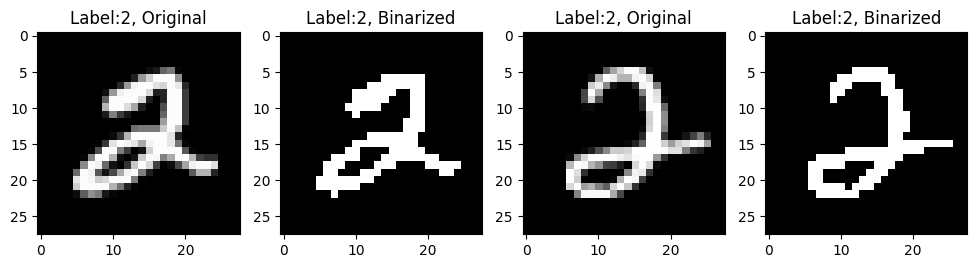

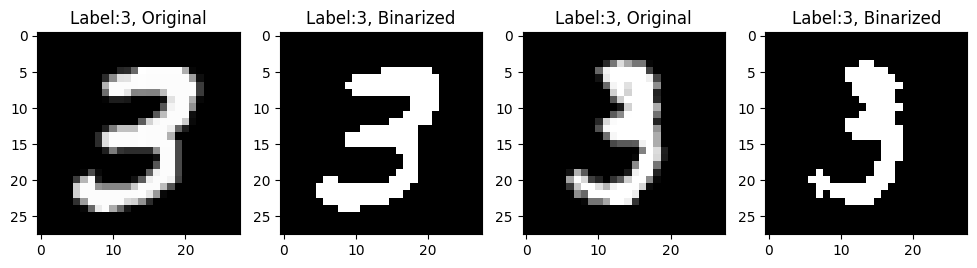

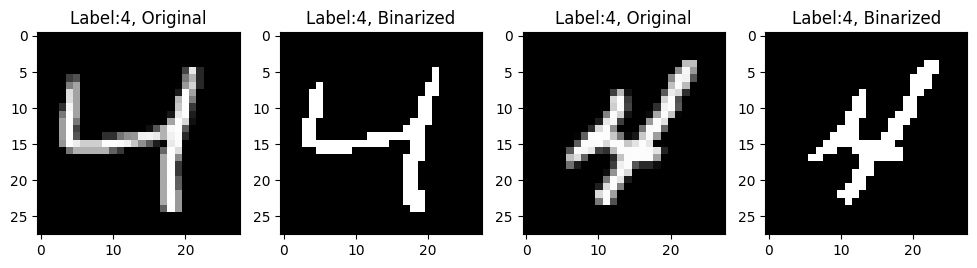

In [10]:
for digit in [2,3,4]:
    
    fig = plt.figure(figsize=(12,7))
    index = np.where(train_labels == digit)[0][:2]

    plt.subplot(141)
    plt.imshow(train_data[index[0]].reshape(28,28),cmap='gray')
    plt.title("Label:" + str(train_labels[index[0]]) + ", Original")
    plt.subplot(142)
    plt.imshow(bin_train_data[index[0]].reshape(28,28),cmap='gray')
    plt.title("Label:" + str(train_labels[index[0]])+ ", Binarized")
    plt.subplot(143)
    plt.imshow(train_data[index[1]].reshape(28,28),cmap='gray')
    plt.title("Label:" + str(train_labels[index[1]]) + ", Original")
    plt.subplot(144)
    plt.imshow(bin_train_data[index[1]].reshape(28,28),cmap='gray')
    plt.title("Label:" + str(train_labels[index[1]])+ ", Binarized")
    plt.show()


In [12]:
from scipy.special import logsumexp

def E_step(X, mu, pi):
    e = 1e-10
    gamma = X @ np.log(mu + e).T + (1. - X) @ np.log(1. - mu + e).T + np.log(pi)
    # Log sum trick: http://bayesjumping.net/log-sum-exp-trick/
    return np.exp(gamma - logsumexp(gamma, axis=1, keepdims=True))

In [13]:
n_test = 5
X_test = bin_train_data[:n_test]
D_test, K_test = X_test.shape[1], 10

np.random.seed(2018)
mu_test = np.random.uniform(low=.25, high=.75, size=(K_test,D_test))
pi_test = np.ones(K_test) / K_test

gamma_test = E_step(X_test, mu_test, pi_test)
assert gamma_test.shape == (n_test, K_test)


In [14]:
def M_step(X, gamma):
    N_k = np.sum(gamma, axis = 0)
    pi = N_k/np.sum(gamma, axis=(0,1))
    
    gamma = gamma.T
    X = X.T
    
    gamma = np.expand_dims(gamma, axis=1)
    mu_unnorm = np.sum(gamma * X, axis =2)
    mu = mu_unnorm.T/N_k
    return mu.T, pi
    
    

In [15]:
mu_test, pi_test = M_step(X_test, gamma_test)

assert mu_test.shape == (K_test,D_test)
assert pi_test.shape == (K_test, )


In [16]:
from tqdm import tqdm_notebook as tqdm

def EM(X, K, max_iter, mu=None, pi=None, output=0):
    N = X.shape[0]
    D = X.shape[1]
    eps = 1e-5
    
    if mu is None:
        mu = np.random.uniform(low=.25, high=.75, size = (K, D))
        
    if pi is None:
        pi = np.ones(K) / K
    
    gamma = np.zeros((N, K))
    for i in tqdm(range(max_iter)):
        
        gamma_new = E_step(X, mu, pi)
        
        mu, pi = M_step(X, gamma_new)
    
        delta_gamma = np.linalg.norm(gamma_new - gamma) / N
        
        if output and not (i%output):
            print(f"Step {i}: delta: {delta_gamma}")          
        
        if delta_gamma < eps:
            break
        gamma = gamma_new
    
    return mu, pi, gamma

/tmp/ipykernel_120697/3503038536.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(max_iter)):


  0%|          | 0/100 [00:00<?, ?it/s]

Step 0: delta: 0.018120958402038985
Step 10: delta: 0.000899903007788482
Step 20: delta: 0.00036861294899425215
Step 30: delta: 1.8951805036566935e-05


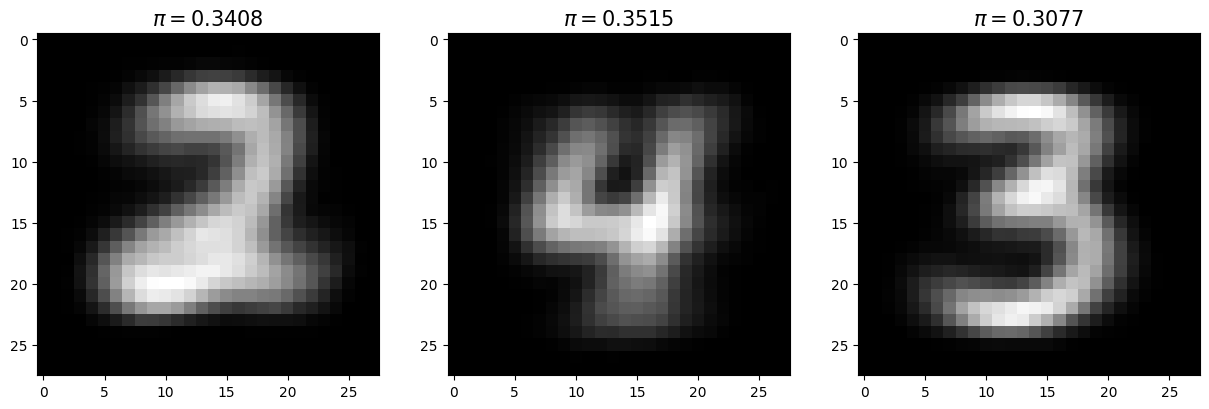

In [17]:
def get_training_data(all_data, all_labels, labels, nr_samples=3):
    
    len_t_data = len(labels) * nr_samples
    out_data = np.empty((len_t_data, 784))
    out_labels = np.empty((len_t_data, 1))
    
    for i, d in enumerate(labels):
        
        # Get indices of interest
        digit_i = np.argwhere(all_labels == d)
        digit_i = digit_i.reshape(digit_i.shape[0])
        
        # Chose a random sample from those digits
        dig_i_sample = np.random.choice(digit_i, nr_samples, replace=False)
        
        # Get the corresponding data and binarize it.
        dig_data = binarize(all_data[dig_i_sample])
        
        # add labels and data to the output
        start_i = i * nr_samples
        end_i = (i + 1) * nr_samples
        out_labels[start_i:end_i] = d * np.ones((nr_samples,1))
        out_data[start_i:end_i] = dig_data
        
    return out_data, out_labels

def plot_mu_pi(K, mu, pi, title_string=None):
    K  = mu.shape[0]
    figure(figsize=(5*K,11))
    if title_string is not None:
        suptitle(title_string, size=50)
    for i in range(K):
        subplot(1,K,i+1)
        imshow(mu[i].reshape(28,28), cmap='gray')
        title(f'$\pi={str(round(pi[i], 4))}$', size=15)
    
classes = [2,3,4]
max_iter = 100
train_subset, subset_labels = get_training_data(train_data, train_labels, classes, nr_samples=1000)
rez_mu, rez_pi, _ = EM(train_subset, len(classes), max_iter, output=10)
plot_mu_pi(3, rez_mu, rez_pi)

/tmp/ipykernel_120697/3503038536.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(max_iter)):


  0%|          | 0/100 [00:00<?, ?it/s]

Step 0: delta: 0.017481359403892806
Step 10: delta: 0.00173210800409348
Step 20: delta: 0.0009565281291145527
Step 30: delta: 0.0009179550890752561
Step 40: delta: 0.0013228367866447604


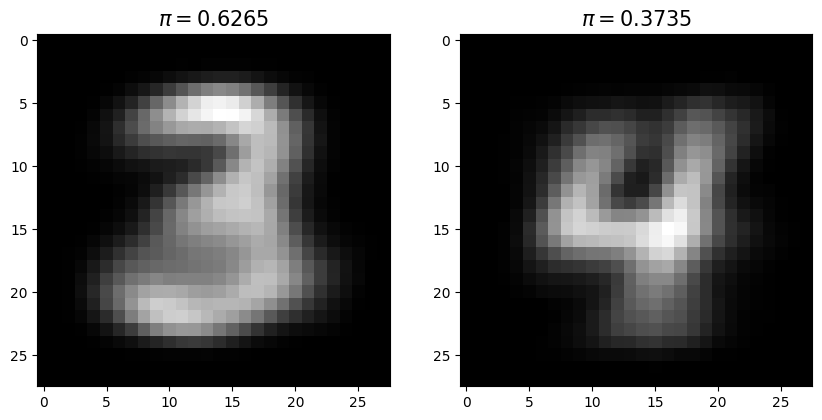

In [18]:
classes = [2,3,4]
max_iter = 100
train_subset, subset_labels = get_training_data(train_data, train_labels, classes, nr_samples=1000)
rez_mu, rez_pi, _ = EM(train_subset, 2, max_iter, output=10)
plot_mu_pi(2, rez_mu, rez_pi)

/tmp/ipykernel_120697/3503038536.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(max_iter)):


  0%|          | 0/100 [00:00<?, ?it/s]

Step 0: delta: 0.016737460045928
Step 10: delta: 0.0025549198068058657
Step 20: delta: 0.0009934886609733649
Step 30: delta: 0.0003327281995306063
Step 40: delta: 0.0003979406772857829
Step 50: delta: 0.00035025325185234293
Step 60: delta: 0.0005623813203930081
Step 70: delta: 9.271781596718495e-05
Step 80: delta: 0.00013201371327802448
Step 90: delta: 2.1584949043031172e-05


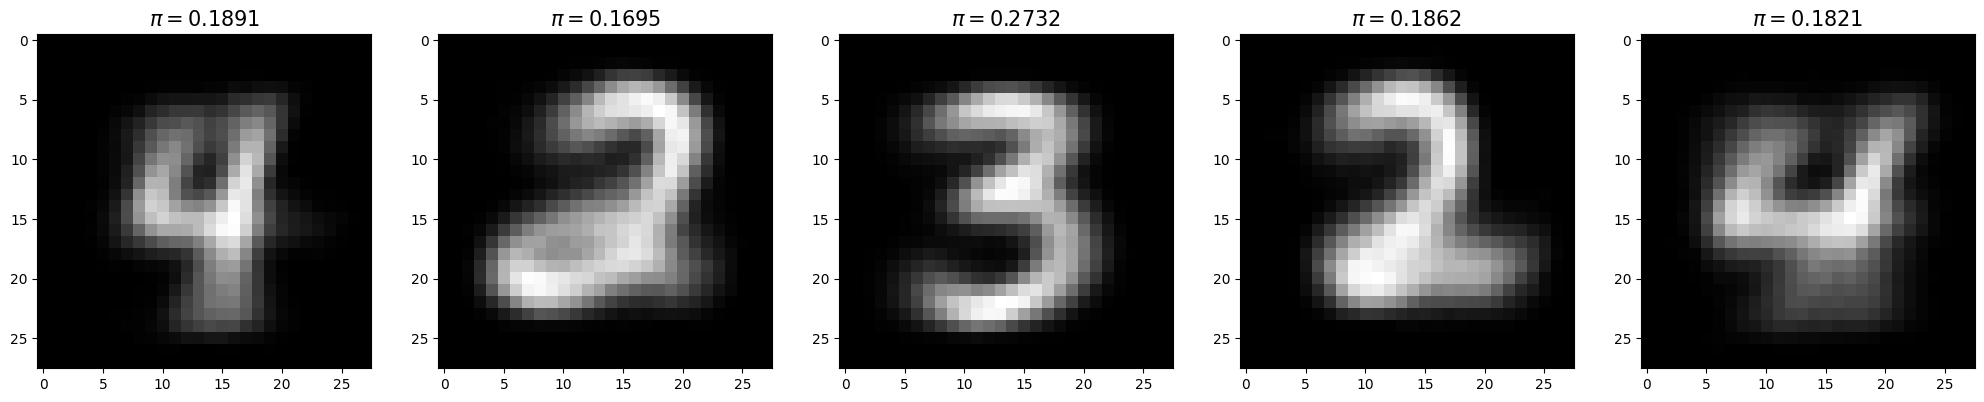

In [19]:
classes = [2,3,4]
max_iter = 100
train_subset, subset_labels = get_training_data(train_data, train_labels, classes, nr_samples=1000)
rez_mu, rez_pi, _ = EM(train_subset, 5, max_iter, output=10)
plot_mu_pi(5, rez_mu, rez_pi)

/tmp/ipykernel_120697/3503038536.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(max_iter)):


  0%|          | 0/100 [00:00<?, ?it/s]

Step 0: delta: 0.5593566689051498


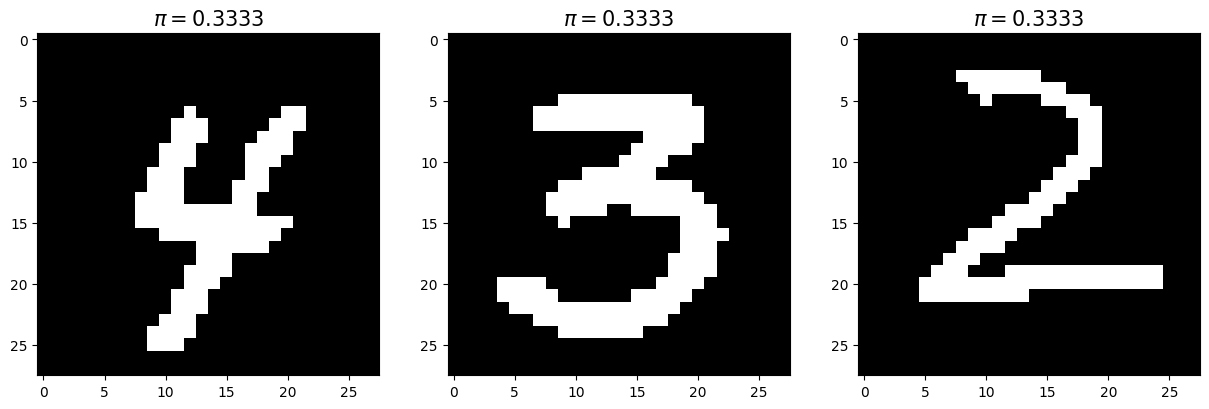

In [20]:
classes = [2,3,4]
max_iter = 100
train_subset, subset_labels = get_training_data(train_data, train_labels, classes, nr_samples=1)
rez_mu, rez_pi, _ = EM(train_subset, 3, max_iter, output=10)
plot_mu_pi(5, rez_mu, rez_pi)

/tmp/ipykernel_120697/3503038536.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(max_iter)):


  0%|          | 0/100 [00:00<?, ?it/s]

Step 0: delta: 0.016987286082004106
Step 10: delta: 0.0005967533218203411
322 misclassified images out of 3000


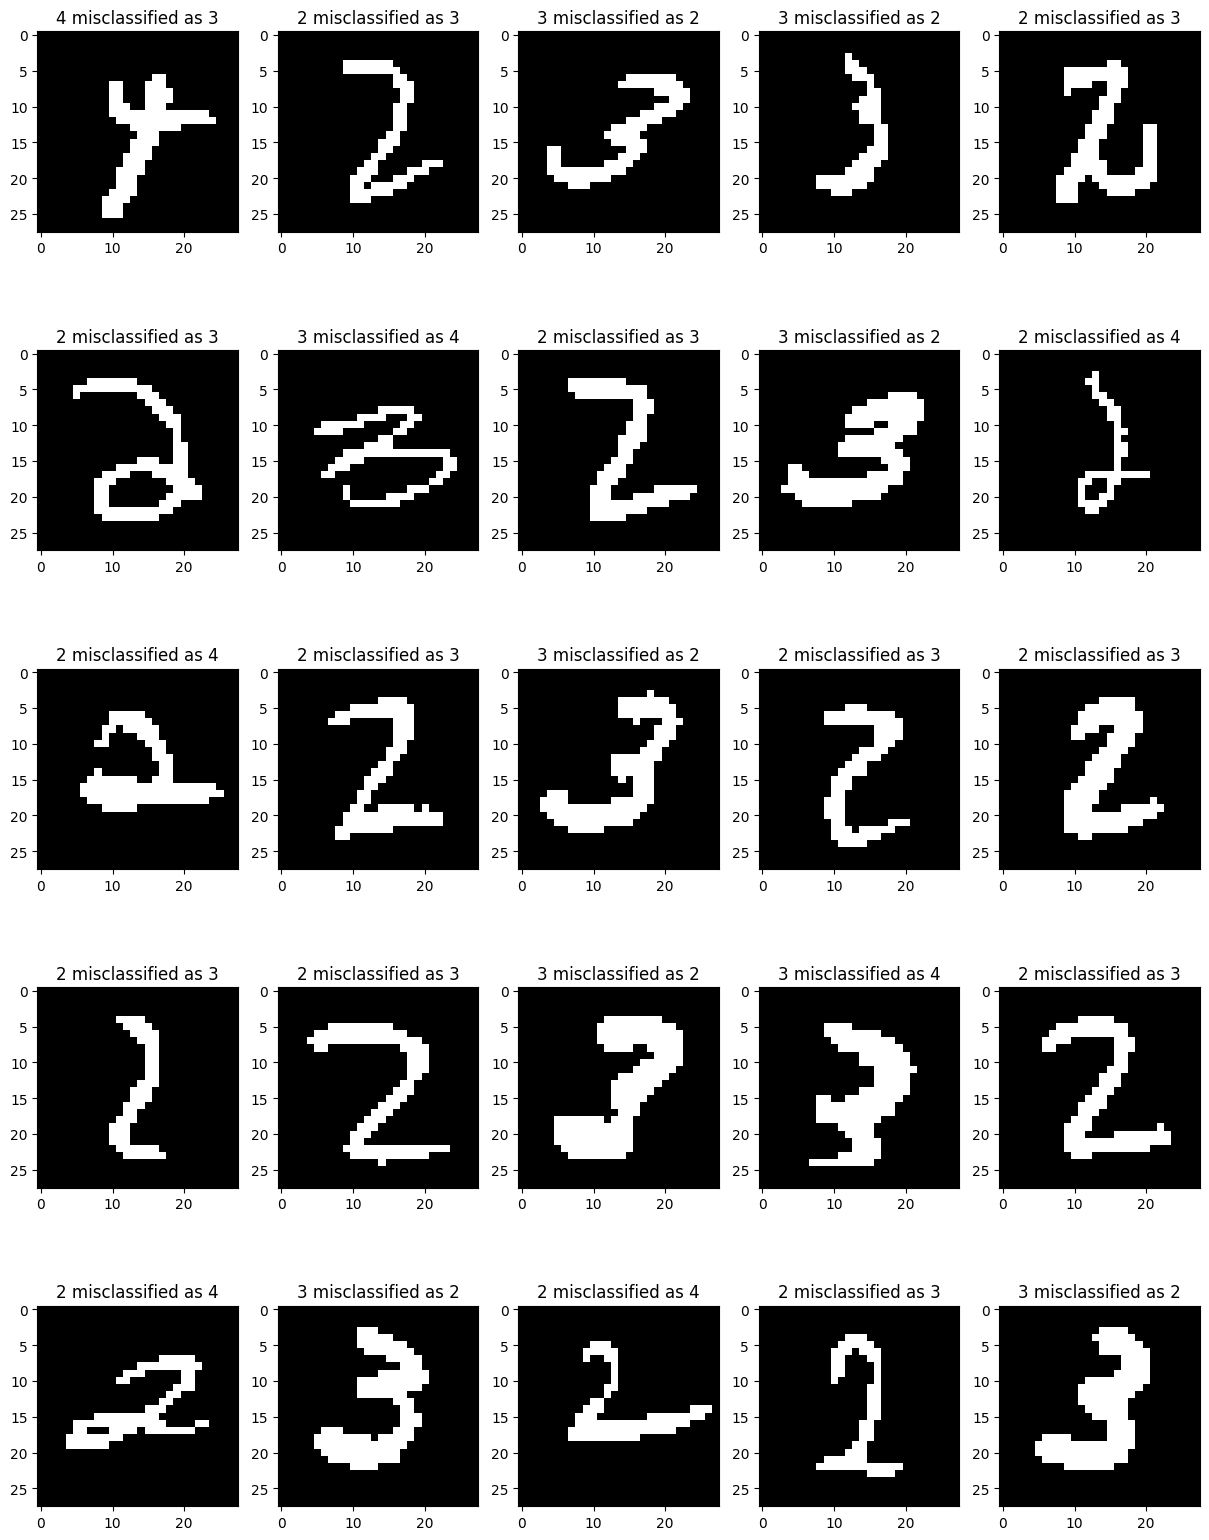

In [21]:
from collections import defaultdict

def test_classification(data, labels, assigned_classes):
    
    # identify the missclassfication
    misclassified_indexes = assigned_classes != labels    
    number_of_errors = sum(misclassified_indexes)    

    print('{} misclassified images out of {}'.format(number_of_errors, len(data)))    

    # get some random examples to show
    sampled_indexes = np.where(misclassified_indexes)[0]
    rows = 5
    columns = 5
    sampled_indexes = np.random.choice(sampled_indexes, rows*columns)

    fig, axes = plt.subplots(rows, columns, figsize=(15, rows*4))

    for i in range(len(sampled_indexes)):

        ax = axes[i//columns, i % columns]

        ax.imshow(data[sampled_indexes[i]].reshape(28,28),cmap='gray') 
        ax.set_title("{} misclassified as {}".format(labels[sampled_indexes[i]], assigned_classes[sampled_indexes[i]]))

    plt.show()
    
def label_clusters(classes, class_scores):
    cluster_classes = np.zeros(len(classes))

    for i, k in enumerate(classes):
        c_idxs = subset_labels == k
        cluster_classes[i] = classes[class_scores[:, c_idxs].sum(axis=1).argmin()]
        
    return cluster_classes

def cluster_classification(classes, rez_mu, train_subset):
    
    # Calculates the pixel-wise squared error for each class vs datapoint
    class_scores = ((np.expand_dims(rez_mu, axis=1) - train_subset)**2).sum(axis=2)
    
    # Finds which cluster corresponds to each class
    cluster_classes = label_clusters(classes, class_scores)
    
    # Class assignment based on cluster indexing 
    class_assignment = cluster_classes[class_scores.argmin(axis=0)].astype(int)
    
    return class_assignment
    
    

# retrain the model to avoid interference of other cells
classes = np.array([2, 3, 4]).astype(int)
max_iter = 100
train_subset, subset_labels = get_training_data(train_data, train_labels, classes, nr_samples=1000)
rez_mu, rez_pi, rez_gamma = EM(train_subset, len(classes), max_iter, output=10)

subset_labels = np.squeeze(subset_labels).astype(int)

class_assignment = cluster_classification(classes, rez_mu, train_subset)

# Finds the missclassifications
test_classification(train_subset, subset_labels, class_assignment)

1659 misclassified images out of 3000


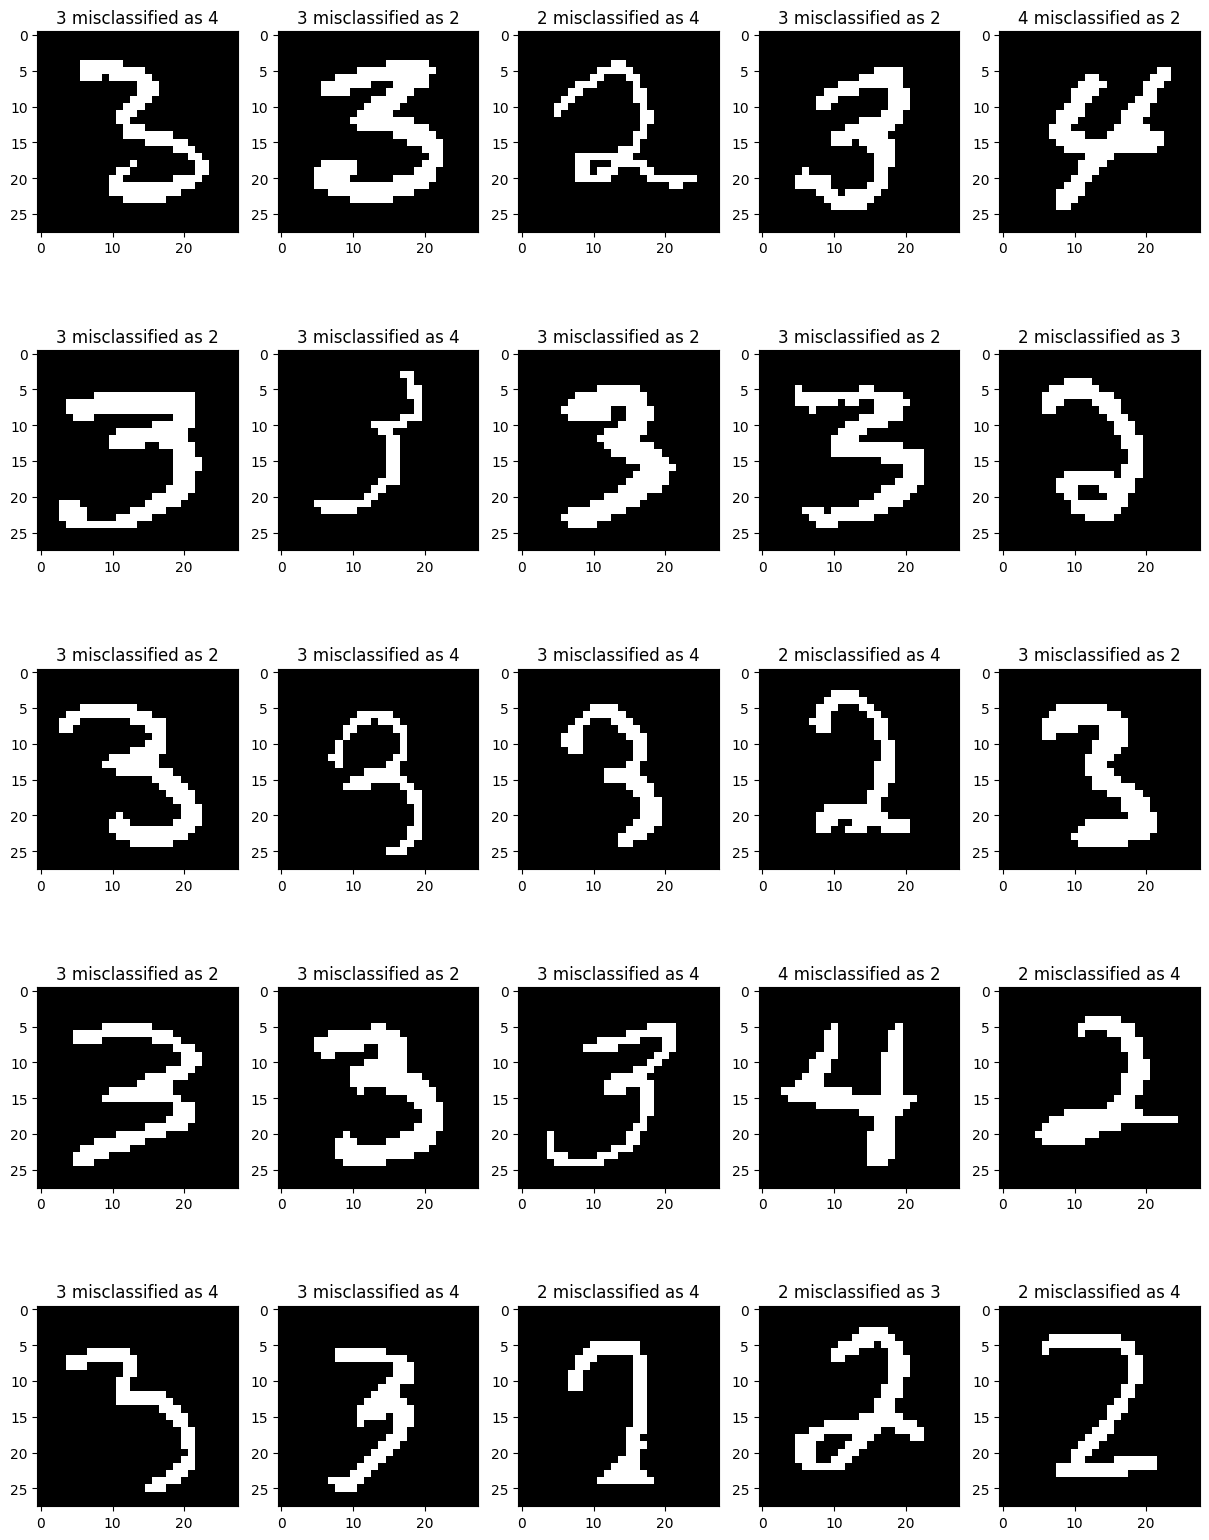

In [24]:
# from scipy.stats import itemfreq

classes = np.array([2, 3, 4]).astype(int)
max_iter = 100
train_subset, subset_labels = get_training_data(train_data, train_labels, classes, nr_samples=1000)

subset_labels = np.squeeze(subset_labels).astype(int)

# initilize pi
values, counts = np.unique(subset_labels, return_counts=True)
freqs = list(zip(values, counts))
l_freq = np.array([freq[1] for freq in freqs])
pi = l_freq.astype(float) / len(subset_labels)


# l_freq = itemfreq(subset_labels)
# pi = l_freq[:, 1].astype(float) / len(subset_labels)

# initialize mu
K = len(classes)
mu = np.zeros((K, train_subset.shape[1]))
for i, c in enumerate(classes):
    mu[i] = train_subset[subset_labels == c].mean()
    
# Without EM:

class_assignment = cluster_classification(classes, mu, train_subset)

test_classification(train_subset, subset_labels, class_assignment)

/tmp/ipykernel_120697/3503038536.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(max_iter)):


  0%|          | 0/100 [00:00<?, ?it/s]

Step 0: delta: 0.015255597710769857
Step 10: delta: 0.0027452698075888034
Step 20: delta: 0.00036335895327364604
Step 30: delta: 4.115643026056133e-05
285 misclassified images out of 3000


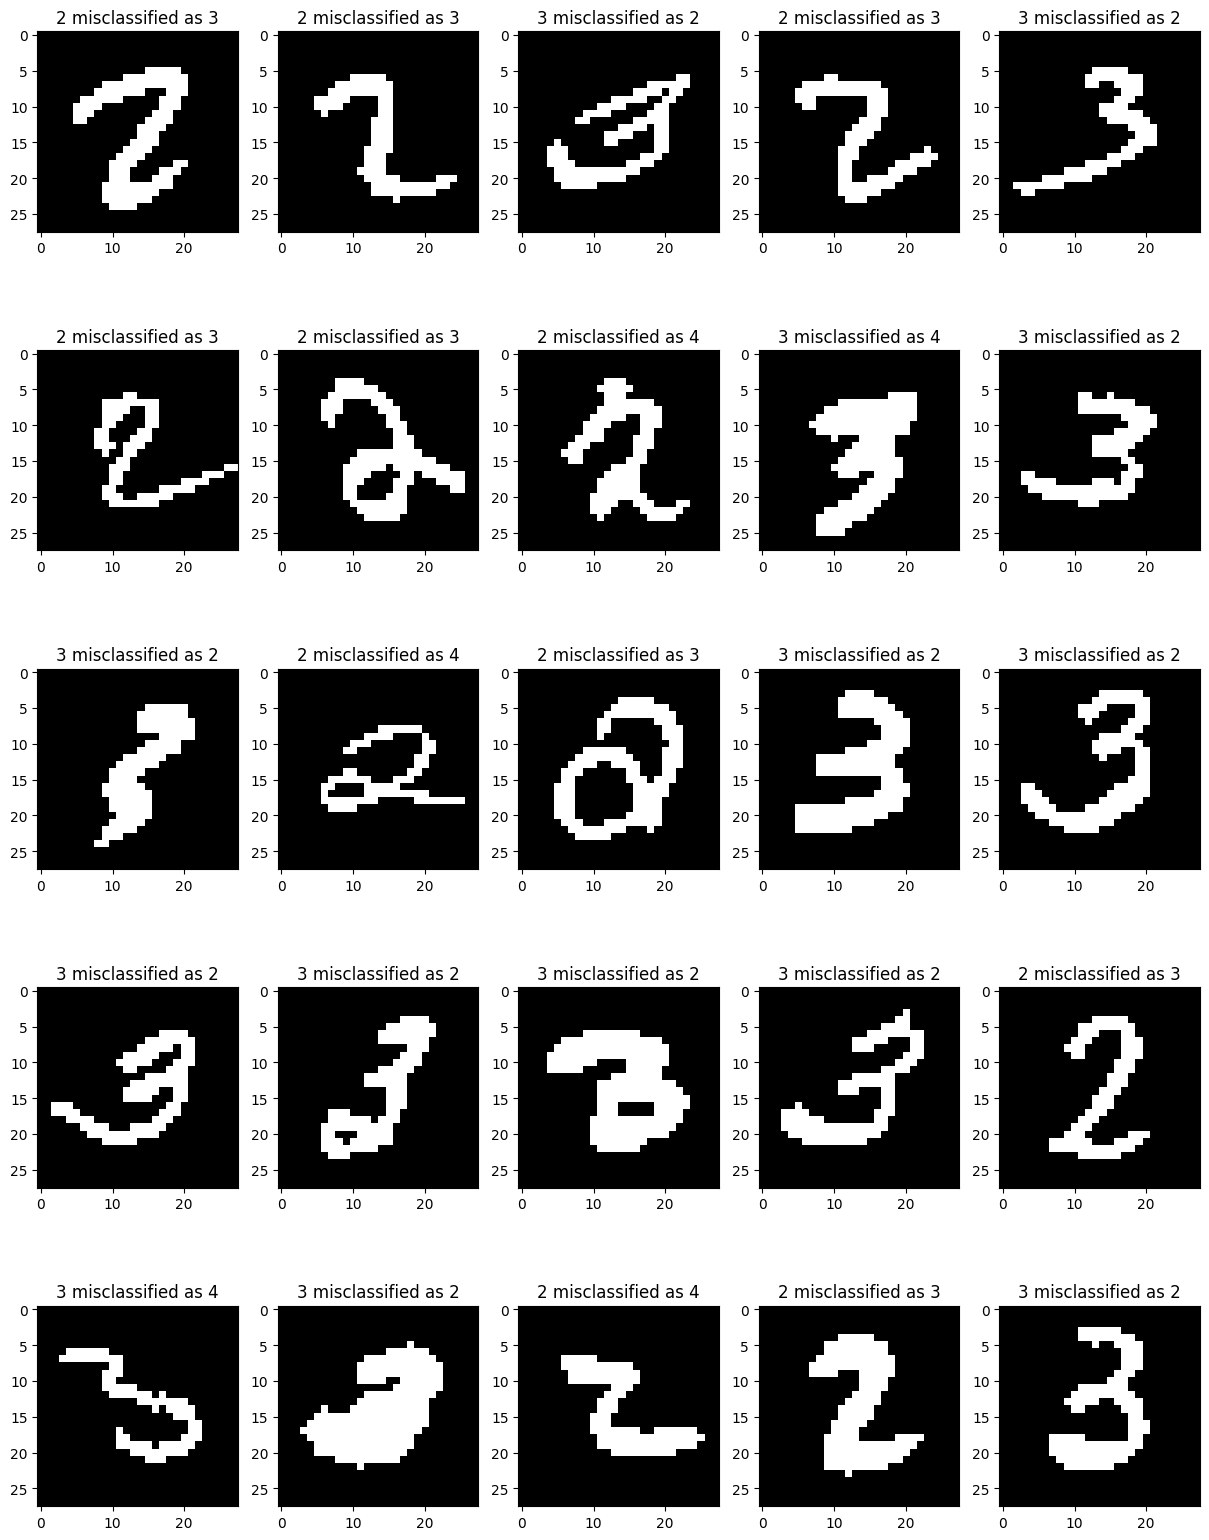

In [25]:
# With warm-started EM:

rez_mu, rez_pi, rez_gamma = EM(train_subset, len(classes), max_iter, output=10, mu=mu, pi=pi)

class_assignment = cluster_classification(classes, rez_mu, train_subset)

test_classification(train_subset, subset_labels, class_assignment)